### Workflow
#### 5.A) Modelling
5.1 Loading the prepared data (see notebook "Data_Preprocesing_Step_2-4")

5.2 Predict next 49 days through Simple Exponential Smoothing without considering features (only target cloumn)

#### 6.A) Evaluation
6.1 Combing Prediction- and Test-Data to an evaluation df 

6.2 Visual Evaluation

6.3 Examination of results resampled to 7 weeks (instead of 49days)

6.4 Scores - calculating the prediction quality scores defined in the Project Proposal

# 5.A) Modelling

### 5.1 Lodaing the prepared data

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load data 
df = pd.read_csv('prepared_data_all.csv')
df.head()

,Unnamed: 0,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,ID,StoreType,Assortment,CompetitionDistance,Promo_2_active,Open_sunday
0,0,1,5,2015-07-31,5263,1,1,1,1,0,2,0,1270,0,0
1,1,2,5,2015-07-31,6064,1,1,1,1,1,0,0,570,1,0
2,2,3,5,2015-07-31,8314,1,1,1,1,2,0,0,14130,1,0
3,3,4,5,2015-07-31,13995,1,1,1,1,3,2,2,620,0,0
4,4,5,5,2015-07-31,4822,1,1,1,1,4,0,0,29910,0,0


In [3]:
df = df.drop(columns=['Unnamed: 0'])

In [4]:
# change order of df so latest date comes first
df = df.iloc[::-1]

In [5]:
# subset df to only columns 'Date', 'Sales' and 'Store'
target_df = df [['Date', 'Store', 'Sales']]
target_df.head()

,Date,Store,Sales
1017208,2013-01-01,1115,0
1017207,2013-01-01,1114,0
1017206,2013-01-01,1113,0
1017205,2013-01-01,1112,0
1017204,2013-01-01,1111,0


In [6]:
# filter into train/test 

# as defined in Proposal: 
# train range 07.01.2013 – 07.06.2015 (94,7% of data)
# test range 08.06.2015-26.07.2015 (5,3% of data) 

# TRAIN
# Filter out all rows with a date past 07.06.2015
df_train = target_df[target_df['Date']<'2015-06-08']
# Filter out all rows with a date before 07.01.2013
df_train = df_train[df_train['Date']>='2013-07-01']

# TEST
# Filter out all rows with a date before 08.06.2015
df_test = target_df[target_df['Date']>='2015-06-08']
# Filter out all rows with a date past 26.07.2015
df_test = df_test[df_test['Date']<'2015-07-27']

In [7]:
df_train['Date'] = pd.to_datetime(df_train.Date)
df_test['Date'] = pd.to_datetime(df_test.Date)

In [8]:
df_train.head()

,Date,Store,Sales
815394,2013-07-01,1115,7505
815393,2013-07-01,1114,25737
815392,2013-07-01,1113,8873
815391,2013-07-01,1112,21899
815390,2013-07-01,1111,8831


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755185 entries, 815394 to 60210
Data columns (total 3 columns):
Date     755185 non-null datetime64[ns]
Store    755185 non-null int64
Sales    755185 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 23.0 MB


In [10]:
# save final_data_frame for other models evaluation "DeepAR" notebook
pd.DataFrame(df_test).to_csv(os.path.join('actual_sales_evaluation.csv'))

### 5.2 Predict next 49 days through Simple Exponential Smoothing without considering features (only target cloumn)

For the following code the data should only contain the 3 columns 'Date', 'Target' (here sales) and 'Category' (here the different stores). Features are not considered in this simple benchmark prediction!

In [11]:
# Simple Exponential Smoothing
import warnings
warnings.filterwarnings("ignore")
import itertools
import time
import datetime
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


# change data_type of category and target to float32
df_train['Store'] = df_train['Store'].astype('float32')
df_train['Sales'] = df_train['Sales'].astype('float32')

# subset a list of unique Categories to iterate over
category_list = list(df_train['Store'].unique())

#create the basis for final datafram
final_data_frame = pd.DataFrame(columns=['Date','Store','Prediction_Amount','Method','Parameter'])

# optional: define full index which is to be analysed for each Part ID
# full_idx = pd.date_range(start=df_fast_final['Date'].min(), end=df_fast_final['Date'].max(), freq='W')

#Simple Exponential Smoothing Forecasting
for category in category_list:
    df_category = df_train.loc[df_train['Store'] == category]
    # optional: df_category = df_category.set_index('Date')
    # optional: df_category = df_category.reindex(full_idx).fillna(0.0).rename_axis('Date').reset_index()
    #Drop features for indexing when pivot
    df_category = df_category.drop(['Date'], axis = 1)
    df_category = df_category.drop(['Store'], axis = 1)
    df= df_category.to_numpy()  
    
    results = SimpleExpSmoothing(df).fit(smoothing_level=0.1, optimized=False)
    forecast = results.forecast(steps=49)
    forecast[forecast < 0] = 0
    date_index = pd.date_range(start ='06-08-2015', periods=49, freq ='D')
    
    #Frame to append to final frame
    add_frame = pd.DataFrame()
    add_frame['Date'] = date_index
    add_frame['Store'] = category
    add_frame['Prediction_Amount'] = forecast
    add_frame['Method'] = 'SimpleExpSmoothing'
    add_frame['Parameter'] = 'default'

    final_data_frame = final_data_frame.append(add_frame)


#final_data_frame
final_data_frame[final_data_frame['Prediction_Amount'] < 0] = 0

In [12]:
final_data_frame.head()

,Date,Store,Prediction_Amount,Method,Parameter
0,2015-06-08 00:00:00,1115.0,5778.679619,SimpleExpSmoothing,default
1,2015-06-09 00:00:00,1115.0,5778.679619,SimpleExpSmoothing,default
2,2015-06-10 00:00:00,1115.0,5778.679619,SimpleExpSmoothing,default
3,2015-06-11 00:00:00,1115.0,5778.679619,SimpleExpSmoothing,default
4,2015-06-12 00:00:00,1115.0,5778.679619,SimpleExpSmoothing,default


In [13]:
final_data_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54635 entries, 0 to 48
Data columns (total 5 columns):
Date                 54635 non-null object
Store                54635 non-null float64
Prediction_Amount    54635 non-null float64
Method               54635 non-null object
Parameter            54635 non-null object
dtypes: float64(2), object(3)
memory usage: 2.5+ MB


In [14]:
print(final_data_frame[final_data_frame['Store']==5])

                   Date  Store  Prediction_Amount              Method  \
0   2015-06-08 00:00:00    5.0        3791.340315  SimpleExpSmoothing   
1   2015-06-09 00:00:00    5.0        3791.340315  SimpleExpSmoothing   
2   2015-06-10 00:00:00    5.0        3791.340315  SimpleExpSmoothing   
3   2015-06-11 00:00:00    5.0        3791.340315  SimpleExpSmoothing   
4   2015-06-12 00:00:00    5.0        3791.340315  SimpleExpSmoothing   
5   2015-06-13 00:00:00    5.0        3791.340315  SimpleExpSmoothing   
6   2015-06-14 00:00:00    5.0        3791.340315  SimpleExpSmoothing   
7   2015-06-15 00:00:00    5.0        3791.340315  SimpleExpSmoothing   
8   2015-06-16 00:00:00    5.0        3791.340315  SimpleExpSmoothing   
9   2015-06-17 00:00:00    5.0        3791.340315  SimpleExpSmoothing   
10  2015-06-18 00:00:00    5.0        3791.340315  SimpleExpSmoothing   
11  2015-06-19 00:00:00    5.0        3791.340315  SimpleExpSmoothing   
12  2015-06-20 00:00:00    5.0        3791.340315  

# 6.A) Evaluation

### 6.1 Combing Prediction- and Test-Data to an evaluation df

In [15]:
# change datatypes
final_data_frame['Store'] = final_data_frame['Store'].astype('int')
final_data_frame['Date'] = pd.to_datetime(final_data_frame['Date'], format='%Y-%m-%d')
final_data_frame.head()

,Date,Store,Prediction_Amount,Method,Parameter
0,2015-06-08,1115,5778.679619,SimpleExpSmoothing,default
1,2015-06-09,1115,5778.679619,SimpleExpSmoothing,default
2,2015-06-10,1115,5778.679619,SimpleExpSmoothing,default
3,2015-06-11,1115,5778.679619,SimpleExpSmoothing,default
4,2015-06-12,1115,5778.679619,SimpleExpSmoothing,default


In [16]:
# save final_data_frame for other models evaluation "DeepAR" notebook
pd.DataFrame(final_data_frame).to_csv(os.path.join('prepared_evaluation.csv'))

In [17]:
# append final_data_frame['Prediction_Amount'] to df_test based on Date and Store column 
evaluation_df = pd.merge(df_test, final_data_frame,  how='left', left_on=['Date','Store'], right_on = ['Date','Store'])
evaluation_df.head()

,Date,Store,Sales,Prediction_Amount,Method,Parameter
0,2015-06-08,1115,5920,5778.679619,SimpleExpSmoothing,default
1,2015-06-08,1114,20368,18507.428079,SimpleExpSmoothing,default
2,2015-06-08,1113,5939,5263.883418,SimpleExpSmoothing,default
3,2015-06-08,1112,7878,7500.092689,SimpleExpSmoothing,default
4,2015-06-08,1111,4567,3580.998695,SimpleExpSmoothing,default


### 6.2 Visual Evaluation

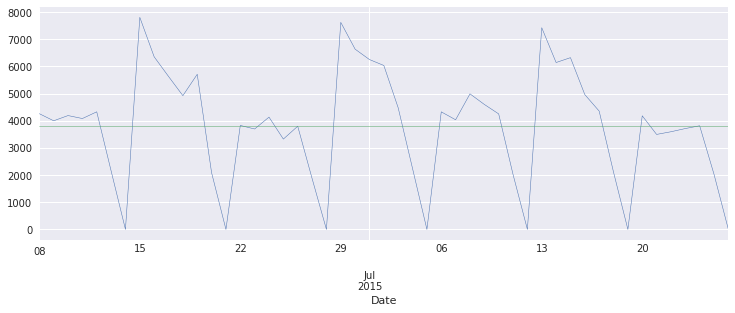

In [18]:
# plot result for one store as example visualization
test_vis_5 = evaluation_df[evaluation_df['Store']==5]

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

test_vis_5 = test_vis_5.set_index('Date')
test_vis_5['Sales'].plot(linewidth=0.5);
test_vis_5['Prediction_Amount'].plot(linewidth=0.5);

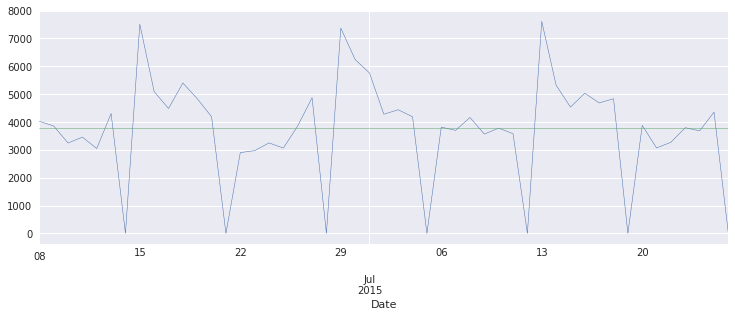

In [19]:
# plot result for one store as example visualization
test_vis_50 = evaluation_df[evaluation_df['Store']==50]

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

test_vis_50 = test_vis_50.set_index('Date')
test_vis_50['Sales'].plot(linewidth=0.5);
test_vis_50['Prediction_Amount'].plot(linewidth=0.5);

### Visual Evaluation Conclusion

This simple prediction seems to capture the average sales quite good, but doesn't account for the demand fluctuation during the weeks. The actual demand is much higher every second week and usually has a spike at the beginning of the week. The simple exponential smoothing only predicts the same amount for each week and doesn't take trend, seasonality or other patterns into concideration.  

### 6.3 Examination of results resampled to 7 weeks (instead of 49days)

In [20]:
# compare the sum of sales over the 49 days 
# sum demand per store (= demand for 7 weeks) in order to compare easier 
# and to check how the prediction quality would change if the data would be aggregated to weeks  

# group prediction per store
evaluation_resampled_pred = evaluation_df.groupby('Store')['Prediction_Amount'].sum().reset_index()
evaluation_resampled_pred.columns = ['Store','Prediction_Amount']

# group actual demand per store
evaluation_resampled_actu = evaluation_df.groupby('Store')['Sales'].sum().reset_index()
evaluation_resampled_actu.columns = ['Store','Sales']

# combine the 2 df
resampled_df = evaluation_resampled_actu.copy()
resampled_df['Prediction_Amount'] = resampled_df.Store.map(evaluation_resampled_pred.set_index('Store')['Prediction_Amount'].to_dict())
resampled_df.head()

,Store,Sales,Prediction_Amount
0,1,178499,167576.464686
1,2,202435,192373.872615
2,3,285635,264367.026916
3,4,404191,389910.210101
4,5,185834,185775.675444


### Conclusion resampled data

It seems that the sum of demand over the 7 weeks prediction period is very close to the sum of actual demand over 7 weeks. Considering this use case I guess it is more comon for a manager to order on a two-weekly or weekly basis than on a daily basis. So this result might actually be kind of good for this use case. Let's have a look at evaluation scores. 

### 6.4 Scores - calculating the prediction quality scores defined in the Project Proposal

#### for the regualr data (per day)

In [21]:
y_true = evaluation_df['Sales'].to_numpy()
y_pred = evaluation_df['Prediction_Amount'].to_numpy()

import numpy as np 
rmse = (np.sqrt(np.mean(np.square((y_true - y_pred)))))
print ("The absolute mean error (RMSE) is about {}.".format(round(rmse)))

The absolute mean error (RMSE) is about 2996.0.


In [22]:
df_no_zero = evaluation_df[evaluation_df['Sales'] > 0]
y_true = df_no_zero['Sales'].to_numpy()
y_pred = df_no_zero['Prediction_Amount'].to_numpy()
rmspe = (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))) * 100
print ("The relative (percentage) mean error (RMSPE) is about {}%.".format(round(rmspe)))

The relative (percentage) mean error (RMSPE) is about 28.0%.


#### for the resampled data

In [23]:
y_true = resampled_df['Sales'].to_numpy()
y_pred = resampled_df['Prediction_Amount'].to_numpy()
 
#add epsilon as a very small constant to the denominator so that even in the case that y_true equals 0, the denominator as a whole won’t
EPSILON =  1e-10 
rmse = (np.sqrt(np.mean(np.square((y_true - y_pred)))))
rmspe = (np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true + EPSILON))))) * 100
print ("The absolute mean error (RMSE) is about {}.".format(round(rmse)))
print ("The relative (percentage) mean error (RMSPE) is about {}%.".format(round(rmspe)))


The absolute mean error (RMSE) is about 19921.0.
The relative (percentage) mean error (RMSPE) is about 7.0%.
